# Navigation

In [15]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Device:  cpu
Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## Deep-Q Network

In [23]:
class DQNetwork(torch.nn.Module):
    def __init__(self):
        super(DQNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(37,128)
        self.fc2 = torch.nn.Linear(128,64)
        self.output = torch.nn.Linear(64,4)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.output(x)
        return y

## Replay Buffer

In [24]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

## Network updates and action selection

In [25]:
def update_network(online, target):
    for target, online in zip(target.parameters(), online.parameters()):
        target.data.copy_(online.data)

def select_action(model, state, eps):
    model.eval()
    with torch.no_grad():
        q_values = model(state).cpu().detach().data.numpy().squeeze()
    model.train()
    if np.random.rand() > eps:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

def make_gradient_step(experiences, online_model, target_model, optimizer):
    states, actions, rewards, next_states, dones = experiences
    q_targets_next = target_model(next_states).detach().max(1)[0].unsqueeze(1)
    q_targets = rewards + (0.9 * q_targets_next * (1 - dones))
    q_expected = online_model(states).gather(1,actions)
    loss = F.mse_loss(q_expected, q_targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Network and optimizer initialization

In [26]:
online_model = DQNetwork()
target_model = DQNetwork()
update_network(online_model, target_model)
optimizer = optim.Adam(online_model.parameters(), lr=5e-4)
replay_buffer = ReplayBuffer(10000, 50)

In [27]:
update_every = 10
episodes = 1000
goal_score = 13
model_path = 'dqn-model.pth'

In [28]:
scores = []
scores_window = deque(maxlen=100)
eps = 1.0
eps_decay = 0.995
eps_end=0.01

In [29]:
for i in range(1,episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    step = 0
    while True:
        state = torch.tensor(state, dtype=torch.float32)
        action = select_action(online_model, state, eps)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]   
        reward = env_info.rewards[0]                   
        done = env_info.local_done[0]                  
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        score += reward
        step += 1
        if (step+1) % update_every == 0:
            if(len(replay_buffer)>=50):
                experiences = replay_buffer.sample()
                make_gradient_step(experiences, online_model, target_model, optimizer)
                update_network(online_model, target_model)

        if done:
            break

    eps = max(eps_end, eps_decay*eps)
    scores_window.append(score)
    scores.append(score)
    
    if i % 100 == 0:
        print("Episode {} Average Score {}".format(i, np.mean(scores_window)))
    
    if np.mean(scores_window) >= goal_score:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i - 100, np.mean(scores_window)))
        torch.save(online_model.state_dict(), model_path)
        break

Episode 100 Average Score 0.05
Episode 200 Average Score 1.31
Episode 300 Average Score 4.58
Episode 400 Average Score 5.15
Episode 500 Average Score 6.13
Episode 600 Average Score 8.82
Episode 700 Average Score 10.18
Episode 800 Average Score 11.65

Environment solved in 756 episodes!	Average Score: 13.06


## Result presentation

In [16]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

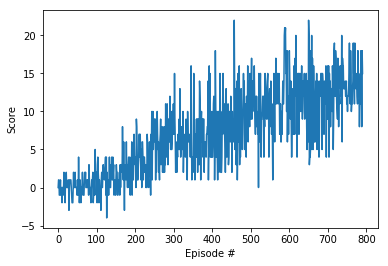

In [17]:
plot_scores(scores)

## Run the trained agent

In [30]:
model = DQNetwork()
model.load_state_dict(torch.load(model_path))
model.eval()

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0 

while True:
    state = torch.tensor(state, dtype=torch.float32)
    action = select_action(model, state, eps)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state

    if done:
        break

print("Score: {}".format(score))

Score: 11.0
